# 1. Library 

In [1]:
## Parameters specific to where your folders are and your data
parameter_file = '../parameters/params.yaml'
import yaml
import sys
import os
with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

#data_folder = doc['data_folder']
#tissues = doc['tissues'].split(',')
#sys.path.append(doc['pipeline_path'])
ref_fa = doc['GENOME_FA']
anno_gff=doc['ANNOTATION']
#mRNA_peak_file = doc["mRNA_peak_file"]
#tss_annotation = doc['tss_annotation']


import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from os.path import join
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm

from os.path import basename
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
#from Homer import *

homer_path =  "/data2/resources/software/homer/v4.11_10242019/bin/"
os.environ['PATH'] = f"{homer_path}:{os.environ['PATH']}"
!which homer

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys


/data2/resources/software/homer/v4.11_10242019/bin//homer


In [2]:
ls GCF/tissues_collapse/

ls: cannot access 'GCF/tissues_collapse/': No such file or directory


In [3]:

os.chdir(doc["results"])
genome="GCF"

save_dir = join("Silenced_CHO_oct062020",genome)
save_dir
tissues_expr_f = "GCF/tissues_collapse/tissues.merge.peaksexpression"
tissues_expr_log10_f = "GCF/tissues_collapse/tissues.merge.peaksexpression.log10"

#if not os.path.exists(save_dir):
#    os.mkdir(save_dir)

# 2. Load and Preprocessing

## Read in expression matrix

In [4]:
tissues_expr = pd.read_csv(tissues_expr_f,sep="\t",index_col=0)
tissues_expr.head()

,MiscOrgans,Liver,Brain,Lung,Heart,CHO,Pancreas,BMDM1hKLA,FemaleReproductive,Muscle,Kidney,Spleen,BMDMwt
0,0.705,0.0,0.790000,2.180000,0.835,26.996,0.000,84.2,0.630,0.715,2.130000,0.000,0.00
1,3.975,1.1,1.608571,16.596667,0.000,0.000,0.000,0.0,4.265,0.545,1.050000,3.385,0.00
2,0.705,0.0,1.887429,2.386667,0.000,19.044,1.490,0.0,4.025,1.100,1.870000,1.255,5.66
3,3.025,0.0,3.914286,1.633333,0.835,1.680,2.385,0.0,6.000,1.495,1.153333,2.875,2.45
4,112.050,29.7,189.308571,50.966667,25.600,20.292,95.500,0.0,136.550,124.150,43.640000,88.550,3.39


In [5]:
tissues_expr_log10 = pd.read_csv(tissues_expr_log10_f,sep="\t",index_col=0)
tissues_expr_log10.head()


,MiscOrgans,Liver,Brain,Lung,Heart,CHO,Pancreas,BMDM1hKLA,FemaleReproductive,Muscle,Kidney,Spleen,BMDMwt
0,0.191009,0.000000,0.192445,0.292457,0.213256,1.379905,0.000000,1.93044,0.177054,0.192803,0.289548,0.000000,0.000000
1,0.658306,0.211156,0.365353,0.875756,0.000000,0.000000,0.000000,0.00000,0.704879,0.160073,0.206016,0.569562,0.000000
2,0.191009,0.000000,0.285237,0.440272,0.000000,1.269450,0.299942,0.00000,0.650337,0.252575,0.377071,0.272654,0.823474
3,0.592983,0.000000,0.633209,0.256951,0.213256,0.347363,0.380588,0.00000,0.556972,0.300486,0.216445,0.583265,0.537819
4,1.998797,0.945703,1.707621,0.729080,0.858835,0.698374,1.141651,0.00000,1.218955,1.198361,0.838893,1.743575,0.642465


### Read in promoter output

In [6]:
tss_meta = pd.read_csv("GCF/eTSS/TSS.meta.tsv",sep="\t",index_col=0)
tss_meta["Name"] = tss_meta.index
tss_meta.set_index("ID",inplace=True)
tss_meta.head()

,Tissues,cs,CHO ATAC Region,Gene,Gene ID,Transcript,Is Experimental,has ATAC,Name
ID,,,,,,,,,
90264.0,"Brain,Spleen,Lung,FemaleReproductive,Kidney,Mi...",0b00,NaN,Bmp4,NaN,XM_027386529.1,1,0,p2@Bmp4_XM_027386529.1
181215.0,"Brain,Spleen,Lung,FemaleReproductive,Kidney,Mi...",0b00,NaN,Bmp4,NaN,XM_027386529.1,1,1,p3@Bmp4_XM_027386529.1
348823.0,"Brain,Spleen,Lung,FemaleReproductive,Kidney,Mi...",0b11,NaN,Bmp4,NaN,XM_027386529.1,1,0,p1@Bmp4_XM_027386529.1
308710.0,"BMDMwt,Brain,Spleen,Lung,Pancreas,FemaleReprod...",0b11,NaN,Bmp4,NaN,XM_027386528.1,1,1,p1@Bmp4_XM_027386528.1
237253.0,"Brain,Spleen,Lung,CHO,FemaleReproductive,MiscO...",0b11,NaN,Cdkn3,NaN,XM_027386531.1,1,0,p1@Cdkn3_XM_027386531.1


In [7]:
repair_genes = ["Mcm7",
                "Ppp2r5a",
                "Pias4",
                "Pbrm1",
                "Parp2"]

In [16]:
repair_df = tss_meta[tss_meta["Gene"].isin(repair_genes)]
repair_df = repair_df[repair_df.index.notna()]

In [18]:
repair_df

,Tissues,cs,CHO ATAC Region,Gene,Gene ID,Transcript,Is Experimental,has ATAC,Name
ID,,,,,,,,,
309273.0,"BMDMwt,Brain,Spleen,Lung,CHO,FemaleReproductiv...",0b11,NaN,Parp2,NaN,XM_027386589.1,1,0,p1@Parp2_XM_027386589.1
510676.0,"Brain,Spleen,Lung,CHO,FemaleReproductive,Kidne...",0b11,21682228:21682790,Pbrm1,NaN,XM_027389540.1,1,1,p1@Pbrm1_XM_027389540.1
425122.0,"BMDMwt,Brain,Spleen,BMDM1hKLA,Lung,CHO,Pancrea...",0b11,NaN,Pbrm1,NaN,XM_027389543.1,1,0,p1@Pbrm1_XM_027389543.1
418683.0,"BMDMwt,Brain,Spleen,BMDM1hKLA,Lung,CHO,Pancrea...",0b11,11041081:11041598,Mcm7,NaN,XM_027415225.1,1,1,p1@Mcm7_XM_027415225.1
13065.0,"BMDMwt,Brain,Spleen,BMDM1hKLA,Lung,CHO,Pancrea...",0b11,11041965:11042342,Mcm7,NaN,XM_027415225.1,1,0,p2@Mcm7_XM_027415225.1
82071.0,"BMDMwt,Brain,Spleen,Lung,CHO,Pancreas,FemaleRe...",0b11,93824:94480,Ppp2r5a,NaN,XM_027418681.1,1,0,p2@Ppp2r5a_XM_027418681.1
89634.0,"BMDMwt,Brain,Spleen,Lung,CHO,Pancreas,FemaleRe...",0b11,NaN,Ppp2r5a,NaN,XM_027418681.1,1,0,p1@Ppp2r5a_XM_027418681.1
525308.0,"BMDMwt,Brain,Spleen,Lung,CHO,Pancreas,FemaleRe...",0b00,NaN,Ppp2r5a,NaN,XM_027418681.1,1,0,p3@Ppp2r5a_XM_027418681.1
279178.0,"BMDMwt,Brain,Spleen,BMDM1hKLA,Lung,CHO,Pancrea...",0b11,NaN,Pias4,NaN,XM_027419277.1,1,0,p1@Pias4_XM_027419277.1


## Extract promoter peaks

In [22]:
gene_tissue = pd.DataFrame(index=repair_df["Gene"].unique(), columns=prom_tissue.columns, dtype=float)
for ind, val in tqdm.tqdm_notebook(repair_df.groupby("Gene")):
    gene_tissue.loc[ind] = prom_tissue.loc[prom_tissue.loc[val.index].sum(axis=1).idxmax()]
gene_tissue

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


,MiscOrgans,Liver,Brain,Lung,Heart,CHO,Pancreas,BMDM1hKLA,FemaleReproductive,Muscle,Kidney,Spleen,BMDMwt
Parp2,10.415,2.730000,8.820000,4.476667,2.835,3.800,0.000,0.00,4.665,3.560,3.146667,3.505,6.98
Pbrm1,2.680,1.320000,8.761429,5.160000,13.950,2.400,3.900,5.54,7.725,3.480,2.950000,7.550,7.73
Mcm7,5.120,6.833333,8.614286,12.340000,9.880,0.000,1.490,10.30,8.185,13.545,9.400000,5.185,27.20
Ppp2r5a,7.705,5.000000,4.512857,5.220000,30.050,1.626,5.285,0.00,5.890,23.900,5.623333,5.500,2.07
Pias4,11.200,2.443333,8.995714,7.763333,2.175,2.240,9.315,2.90,6.550,5.105,6.883333,15.500,6.60


## Create median and max values


## Take the max transcript for the Gene (sum across tissues)
(Also should test the median)

# 4. Extract silenced Genes

## Get CHO less than 1 TPM

In [23]:
pseudocount = 1 # This is b/c 1 was added to TPM in log when taking the average
silenced_cho_1tpm = gene_tissue.loc[gene_tissue["CHO"] < np.log10(1+pseudocount)].index
print("Number of CHO genes less than 1TPM:", len(silenced_cho_1tpm))
silenced_cho_1tpm

Number of CHO genes less than 1TPM: 1


Index(['Mcm7'], dtype='object')

## B and C. More than 75% /100% of the other tissues are on

In [11]:
n_samples = len(gene_tissue.columns)-1 # Remove CHO
cutoffs = dict()
gene_tissue_silenced = gene_tissue.drop(["CHO"],axis=1) < np.log10(1+pseudocount)

num_tissues_silenced = gene_tissue_silenced.sum(axis=1)
cutoffs[75] = num_tissues_silenced[num_tissues_silenced < (1-0.75)*n_samples].index
cutoffs[90] = num_tissues_silenced[num_tissues_silenced < (1-0.9)*n_samples].index

cutoffs[100] = num_tissues_silenced[num_tissues_silenced ==0].index




cho_75 = set(silenced_cho_1tpm).intersection(cutoffs[75])
cho_90 = set(silenced_cho_1tpm).intersection(cutoffs[90])
cho_100 = set(silenced_cho_1tpm).intersection(cutoffs[100])

print("75th percentile number of silenced genes:", len(cho_75))
print("90th percentile number of silenced genes:", len(cho_90))
print("100th percentile number of silenced genes:", len(cho_100))

75th percentile number of silenced genes: 24
90th percentile number of silenced genes: 17
100th percentile number of silenced genes: 8


# 5. Plot silenced genes values

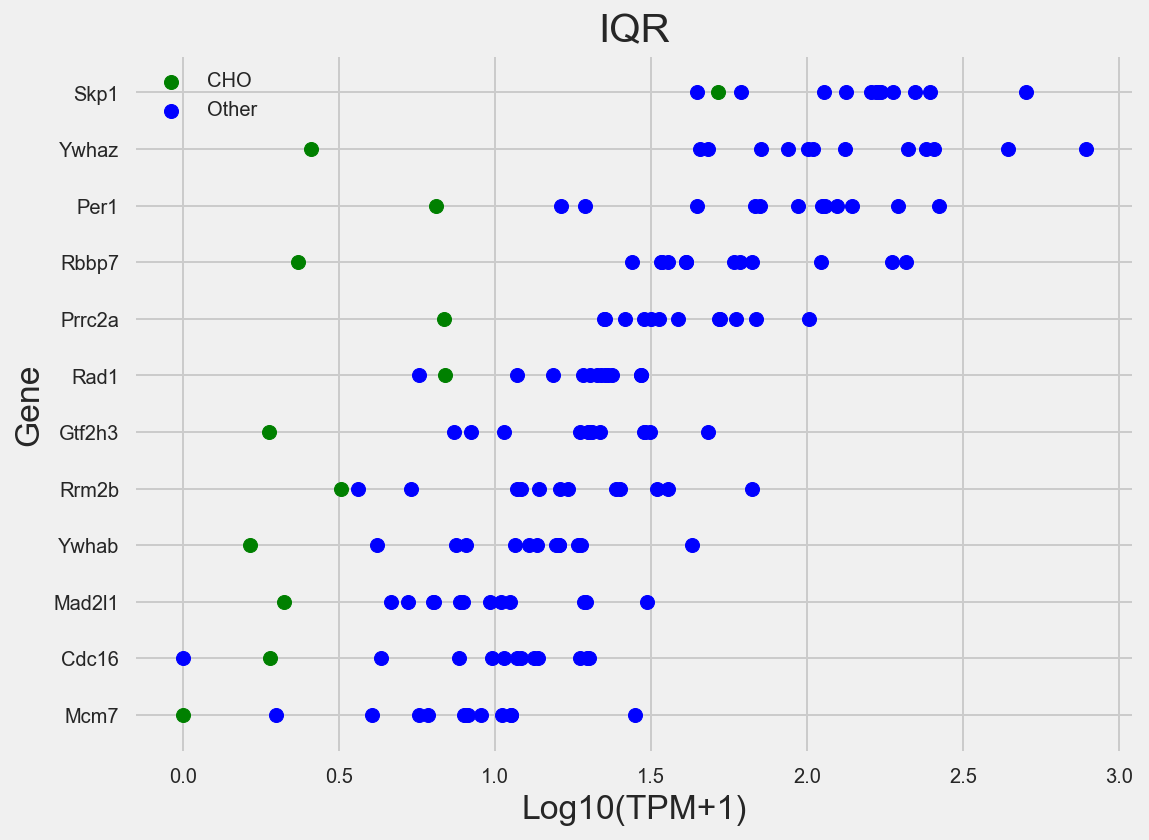

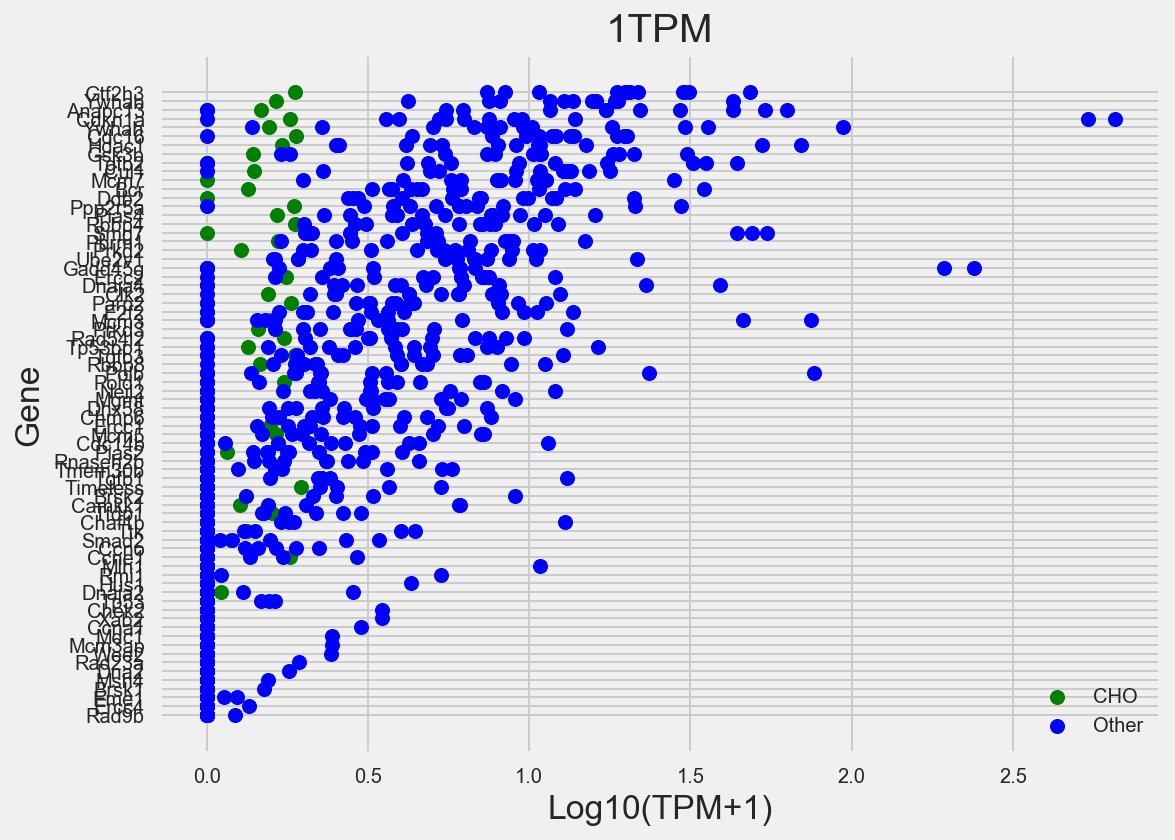

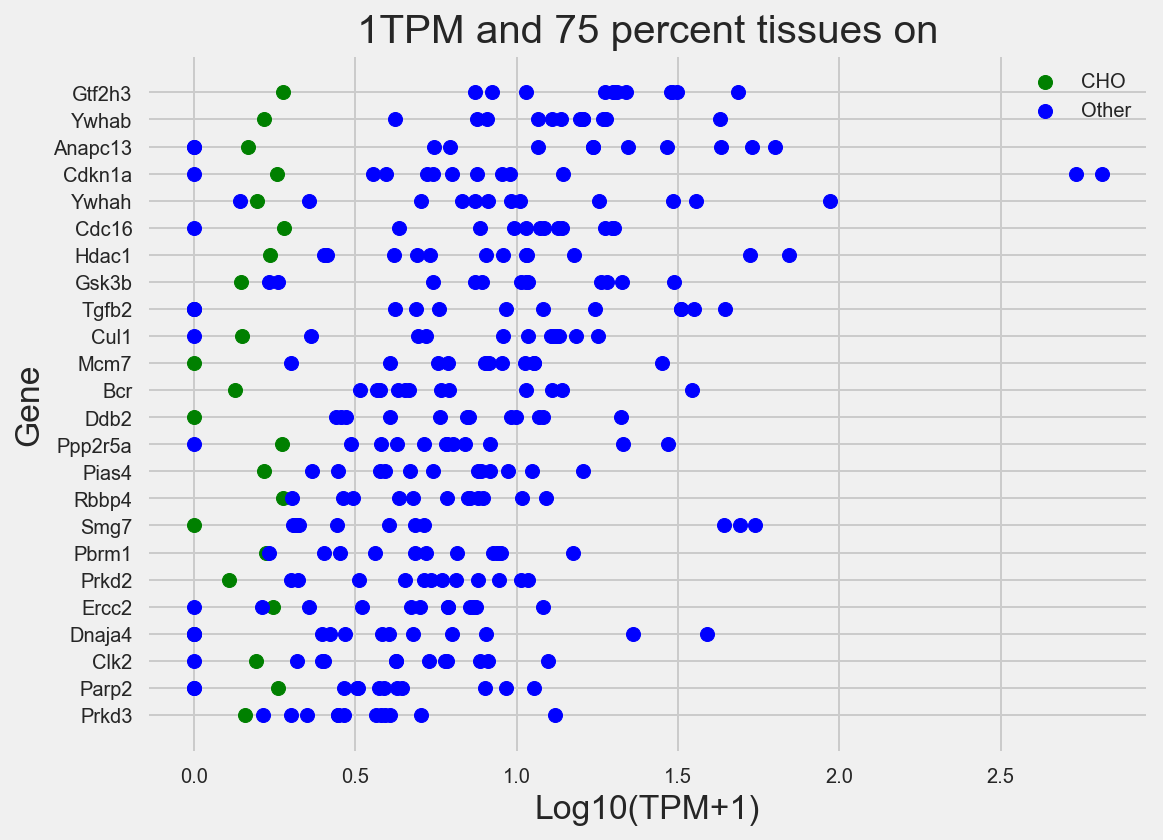

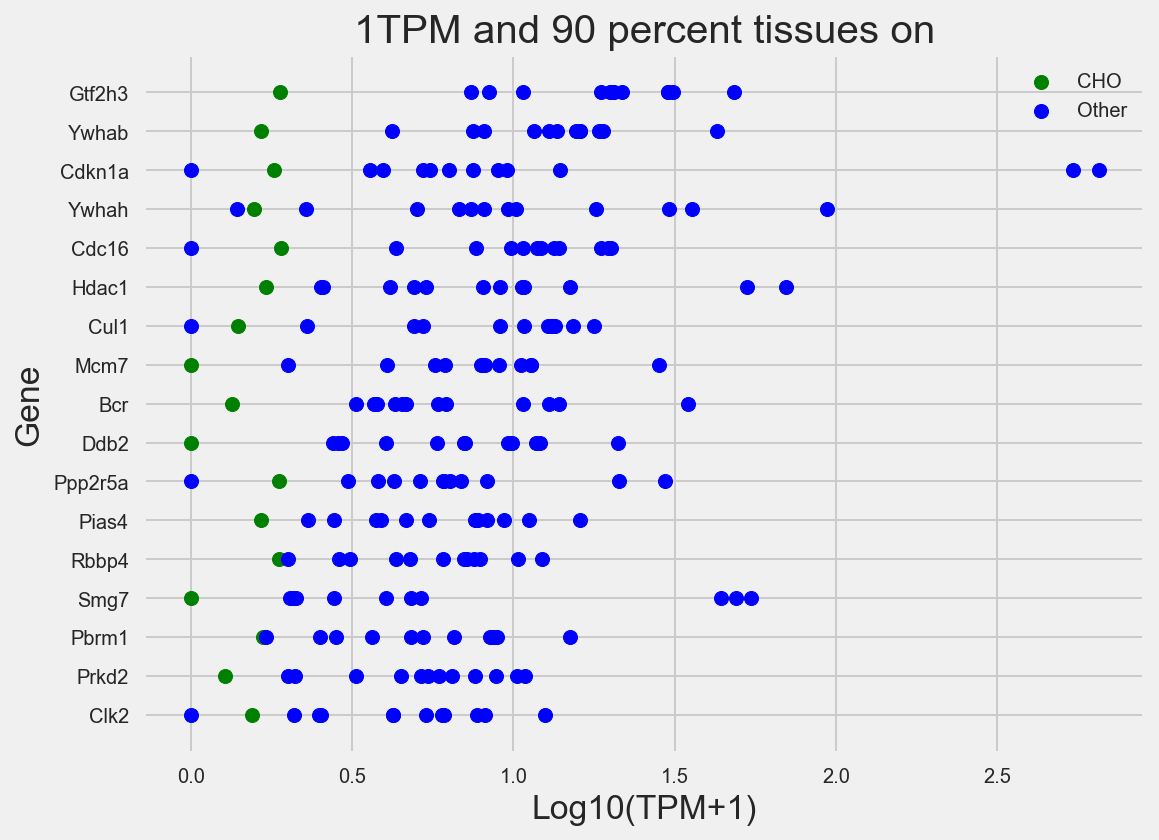

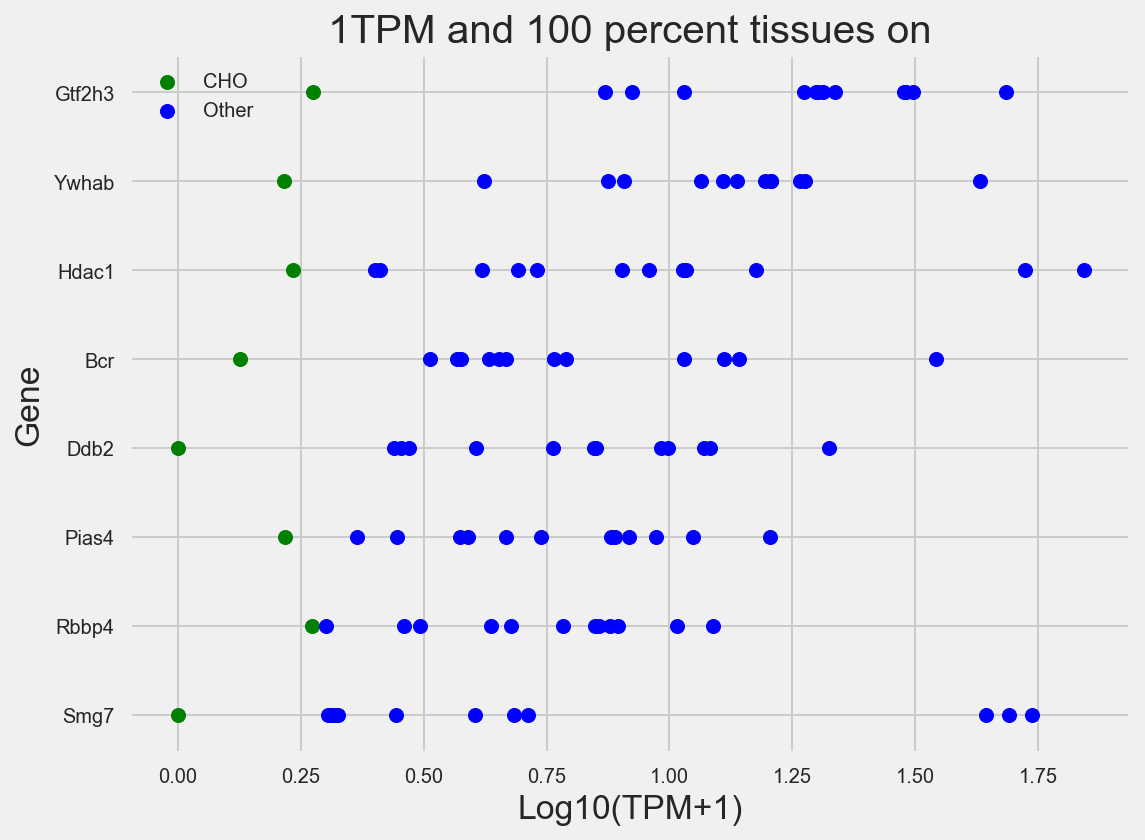

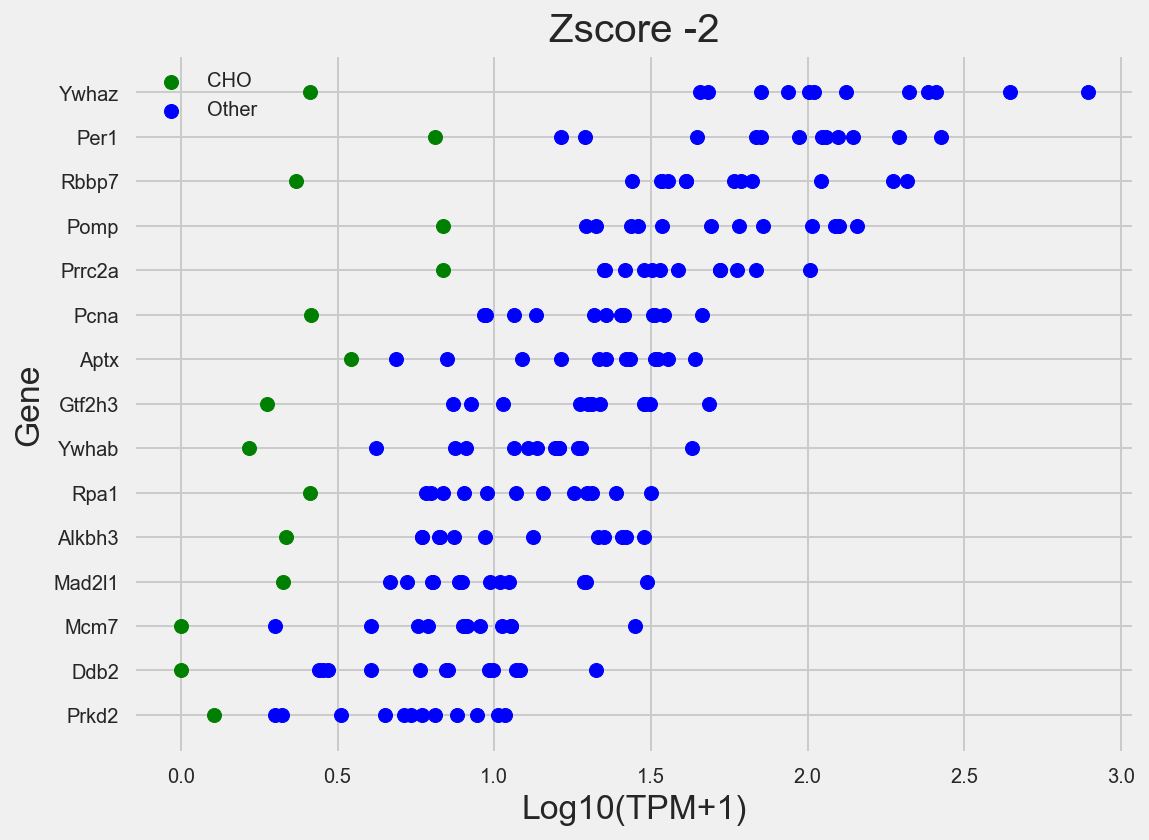

In [62]:
for col in outlier_methods_df.columns.values:
    curr_order = gene_tissue.loc[outlier_methods_df.loc["Genes",col]].apply(lambda x: x.sum(), axis=1).sort_values().index
    curr_genes = gene_tissue.loc[curr_order]
    zip(range(len(curr_genes)), curr_genes.index)

    # Construct scatter values
    cho_scatter_x = []
    cho_scatter_y = []
    tissue_scatter_x = []
    tissue_scatter_y = []
    n_tissues = curr_genes.shape[1] - 1
    for i in zip(range(len(curr_genes)), curr_genes.index):
        cho_scatter_y.append(i[0])
        cho_scatter_x.append(gene_tissue.loc[i[1],"CHO"])
        tissue_scatter_y += [i[0]] * n_tissues
        tissue_scatter_x += list(gene_tissue.drop("CHO",axis=1).loc[i[1]].values)


    f, ax = plt.subplots()
    ax.scatter(cho_scatter_x,cho_scatter_y,color="g")
    ax.scatter(tissue_scatter_x,tissue_scatter_y)
    plt.ylabel("Gene")
    plt.xlabel("Log10(TPM+1)")
    ax.set_yticks(range(len(cho_scatter_y)))
    ax.set_yticklabels(curr_genes.index.values);
    plt.title(col);
    plt.legend(["CHO","Other"])
    name =os.path.join(save_dir,"repair_genes_method_" + col.replace(" ",""))
    plt.savefig(name+".png")
    #gene_tissue.loc[]
    curr_genes.to_csv(name + ".txt")
#     with open(name+".txt","w") as f:
        
#         f.write("\n".join(list(curr_genes.index.values)))

# 6. Calculate TPM ratio

## Log2

TPM ratio Mcm7       3.227556
Ppp2r5a    1.347447
Pias4      1.163837
Pbrm1      0.851166
Parp2     -0.178763
dtype: float64
         MiscOrgans     Liver     Brain      Lung     Heart       CHO  \
Parp2      3.512859  1.899176  3.295723  2.453298  1.939227  2.263034   
Pbrm1      1.879706  1.214125  3.287092  2.622930  3.902074  1.765535   
Ppp2r5a    3.121844  2.584963  2.462800  2.636915  4.956521  1.392867   
Pias4      3.608809  1.783806  3.321310  3.131480  1.666757  1.695994   
Mcm7       2.613532  2.969626  3.265180  3.737687  3.443607  0.000000   

         Pancreas  BMDM1hKLA  FemaleReproductive    Muscle    Kidney  \
Parp2    0.000000   0.000000            2.502076  2.189034  2.051952   
Pbrm1    2.292782   2.709291            3.125155  2.163499  1.981853   
Ppp2r5a  2.651913   0.000000            2.784504  4.638074  2.727557   
Pias4    3.366672   1.963474            2.916477  2.609991  2.978806   
Mcm7     1.316146   3.498251            3.199280  3.862451  3.378512   

   

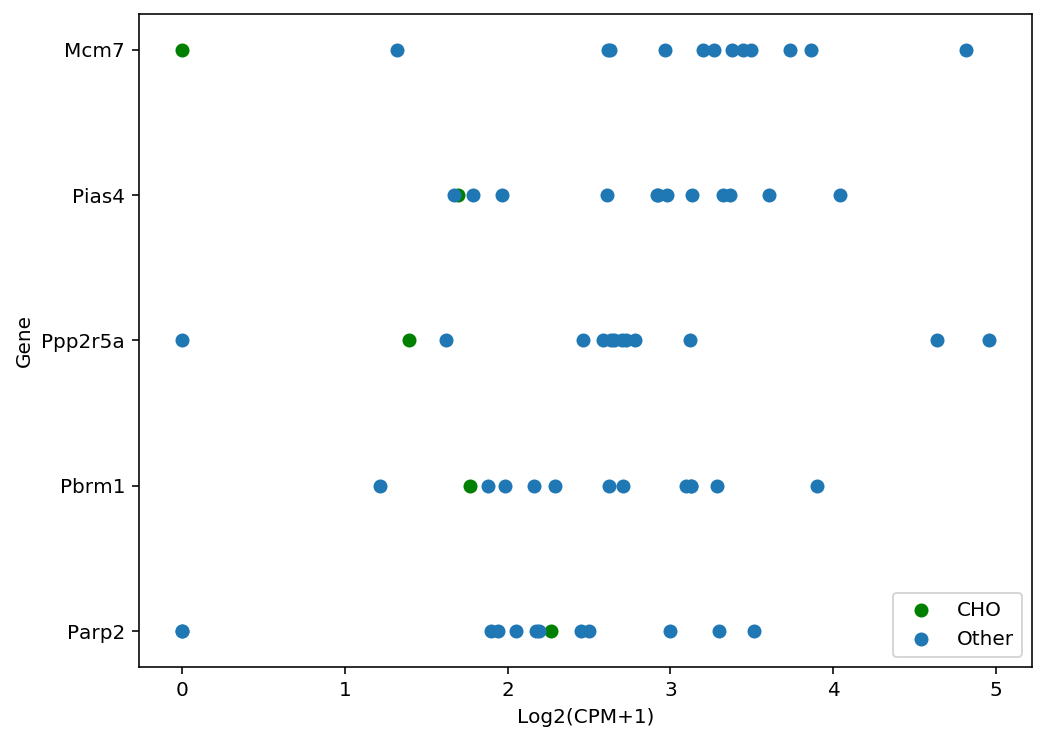

In [27]:
repair_genes = ["Mcm7",
                "Ppp2r5a",
                "Pias4",
                "Pbrm1",
                "Parp2"]

curr_genes = gene_tissue.loc[repair_genes]
# Go into log2
curr_genes = np.log2(curr_genes+1)
gene_tpm_ratio = (curr_genes.drop("CHO",axis=1).mean(axis=1) - curr_genes["CHO"])
gene_tpm_ratio


curr_order = curr_genes.apply(lambda x: x.sum(), axis=1).sort_values().index
curr_genes = curr_genes.loc[curr_order]
zip(range(len(curr_genes)), curr_genes.index)

# Construct scatter values
cho_scatter_x = []
cho_scatter_y = []
tissue_scatter_x = []
tissue_scatter_y = []
n_tissues = curr_genes.shape[1] - 1
for i in zip(range(len(curr_genes)), curr_genes.index):
    cho_scatter_y.append(i[0])
    cho_scatter_x.append(curr_genes.loc[i[1],"CHO"])
    tissue_scatter_y += [i[0]] * n_tissues
    tissue_scatter_x += list(curr_genes.drop("CHO",axis=1).loc[i[1]].values)


f, ax = plt.subplots()
ax.scatter(cho_scatter_x,cho_scatter_y,color="g")
ax.scatter(tissue_scatter_x,tissue_scatter_y)
plt.ylabel("Gene")
plt.xlabel("Log2(CPM+1)")
ax.set_yticks(range(len(cho_scatter_y)))
ax.set_yticklabels(curr_genes.index.values);

plt.legend(["CHO","Other"])
name = os.path.join(save_dir,"repair_genes")


# Save
#helper_save(name+"_log2")

# plt.savefig(name+"_log2.png")
# plt.savefig(name+"_log2.eps")
#gene_tpm_ratio.to_csv(name + "_log2_ratio.txt")

print("CPM ratio", gene_tpm_ratio)
print(curr_genes)

## Do the same but for RNA-seq data

In [57]:
df = pd.DataFrame()
for f in glob.glob("/data/isshamie/TSS/NCBI_PICR_103_Processed/RNAseq/htseq_rev/*.count.txt"):
    curr = pd.read_csv(f,sep='\t', header=None, index_col=0)
    curr = curr[~(curr.index.str.contains('__'))]
    curr.columns = [os.path.basename(f.replace('.count.txt',''))]
    curr = curr.transpose()
    df = df.append(curr)
df = df.transpose()
df

,Muscle_S8,Brain2_S7,Lung_S4,Heart_S6,Misc_S10,Brain7-1_S11,Liver_S5,ReproductiveTract_S2,Kidney_S9,Spleen_S3,Pancreas_S1
0,,,,,,,,,,,
A1cf,14,13,0,0,208,3,2437,3,1136,1,16
A2ml1,41,2,11,1,97,42,46,39,10,67,1
A3galt2,0,0,0,0,0,0,0,0,0,0,0
A4galt,601,12,186,74,264,590,6,796,112,70,12
A4gnt,0,1,0,0,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...
Zxdc,892,429,442,44,520,625,374,836,663,454,28
Zyg11b,1805,3372,555,106,2033,995,1687,1502,1572,671,32
Zyx,614,336,1511,157,616,846,237,963,290,311,43


In [116]:
df.sum()

Muscle_S8               12544540
Brain2_S7               11402105
Lung_S4                 11051157
Heart_S6                10883432
Misc_S10                11813587
Brain7-1_S11             9106097
Liver_S5                13476977
ReproductiveTract_S2    10501274
Kidney_S9               14215209
Spleen_S3                9897029
Pancreas_S1              8081610
dtype: int64

In [69]:
repair_df =  df[df.index.isin(repair_genes)]
repair_df

repair_df["Brain"] = repair_df[["Brain2_S7","Brain7-1_S11"]].mean(axis=1)
repair_df = repair_df.drop(labels=["Brain2_S7","Brain7-1_S11"], axis=1)
repair_df.columns = map(lambda x: x.split("_")[0], repair_df.columns)
repair_df

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Muscle,Lung,Heart,Misc,Liver,ReproductiveTract,Kidney,Spleen,Pancreas,Brain
0,,,,,,,,,,
Mcm7,275,393,25,755,162,875,295,751,9,530.0
Parp2,73,72,1,137,120,171,209,140,4,92.5
Pbrm1,741,1295,59,2087,1352,2793,1308,2480,72,1914.5
Pias4,145,130,39,155,105,135,152,92,12,140.5
Ppp2r5a,572,732,92,1625,906,717,968,1105,35,589.0


## Load in CHO RNA-seq data

In [72]:
doc

{'results': '/data/isshamie/TSS/Analysis/TSS_code/data/processed/',
 'META_SAMPLES': '/data/isshamie/TSS/Analysis/Analysis_03302020/parameters/samples.tsv',
 'peaks_dir': '/data/isshamie/TSS/Analysis/Analysis_NCBI_PICR/f04_peaks/',
 'atac_f': '/data/isshamie/TSS/Analysis/Analysis_NCBI_PICR/Results/ATAC_results/CHO/ATAC_ppr.naive_overlap.narrowPeak.sort',
 'all_atac': '/data/isshamie/TSS/Analysis/Analysis_NCBI_PICR/Results/ATAC_results/ATAC_merge.bed',
 'global': {'PREFIX': 'ncbi_picr_103',
  'ROOT_DIR': '/data/isshamie/TSS/',
  'DATA_DIR': '/data/isshamie/TSS/NCBI_PICR_103_Processed/',
  'RESULTS': '/data/isshamie/TSS/Analysis/TSS_code/data/processed/',
  'SUPPLEMENTAL_DIR': '/data/isshamie/TSS/Analysis/supplemental/',
  'PIPELINE': '/data/isshamie/TSS/Analysis/TSS_code/tss',
  'TISSUES': ['BMDM1hKL',
   'BMDMwt',
   'Brain',
   'FemaleReproductive',
   'Heart',
   'Kidney',
   'Liver',
   'Lung',
   'MiscOrgans',
   'Muscle',
   'Pancreas',
   'Spleen',
   'CHO'],
  'META_FILE': '/dat

In [74]:
cho_rna = pd.read_csv(join(doc["global"]["SUPPLEMENTAL_DIR"], "rna_cho", "tpm_using_picr.txt"), sep='\t')
cho_rna

,gid,gname,1,2,3,4,5,6,7,8,...,SRR2922605,SRR2922606,SRR3401745,SRR3401746,SRR3401747,SRR3401748,SRR3401749,SRR3401750,SRR3401751,SRR3401752
0,gene_10,MCAT,15.090907,14.502347,17.472863,18.938263,16.794809,16.433305,15.446144,15.924950,...,2.818250,0.467242,9.186139,11.062778,9.725346,9.121378,7.273079,8.870101,10.162889,9.457826
1,gene_100,gene_100,0.245168,0.286629,0.118151,0.292011,0.300439,0.176940,0.461869,0.548782,...,0.790368,0.082365,0.516127,0.714297,5.273478,13.265540,13.696956,21.196798,5.535234,17.286073
2,gene_10000_1,SMKX_MOUSE,1.682718,1.522292,2.348422,1.786015,2.357684,1.998047,1.162090,0.373551,...,1.312794,0.167734,0.438990,0.126566,2.739962,1.797872,1.782853,1.061421,3.083283,1.745710
3,gene_10000_10,gene_10000,0.000000,0.000000,0.617603,0.779067,0.201739,0.000000,2.830664,0.000000,...,0.000000,0.000000,0.835100,2.498463,13.903834,4.886355,11.659910,8.752601,16.605154,14.407911
4,gene_10000_11,gene_10000,2.468370,2.586280,1.762731,2.337148,2.911244,3.379113,4.142082,3.166982,...,0.375830,0.004867,4.586689,2.230479,5.982803,2.710943,3.307470,3.586193,6.052315,6.061694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38549,gene_asmbl_81468,gene_asmbl_81468,73.707440,48.084741,50.880658,69.385033,70.889676,99.941183,76.440031,83.965344,...,27.267880,6.074898,54.522609,67.347206,70.928868,72.930698,94.776508,101.521500,80.258244,69.944700
38550,gene_asmbl_81469,gene_asmbl_81469,349.476145,319.975593,372.798721,365.050754,328.463165,377.448268,288.810874,237.051836,...,61.364355,52.701138,536.155844,495.386161,650.087530,517.730457,532.097137,677.404129,690.207209,671.678379
38551,gene_asmbl_83539,gene_asmbl_83539,121.002384,124.818762,124.459545,142.421744,128.031853,131.769659,92.365473,90.107607,...,22.541374,4.560078,142.275358,104.951940,127.571853,86.110240,88.364549,71.687595,128.644800,82.568480
38552,gene_asmbl_83541,gene_asmbl_83541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,25.629605,0.000000,1.088278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [115]:
cho_rna.drop(["gid","gname"], axis=1).sum()

1             1.000000e+06
2             1.000000e+06
3             1.000000e+06
4             1.000000e+06
5             1.000000e+06
                  ...     
SRR3401748    1.000000e+06
SRR3401749    1.000000e+06
SRR3401750    1.000000e+06
SRR3401751    1.000000e+06
SRR3401752    1.000000e+06
Length: 1558, dtype: float64

In [104]:
repair_cho_df = cho_rna[cho_rna["gname"].isin(map(lambda x:x.upper(), repair_genes))]
repair_cho_df = repair_cho_df.drop('gid', axis=1)
repair_cho_df = repair_cho_df.set_index("gname")
repair_cho_df = repair_cho_df.median(axis=1)

repair_cho_df = repair_cho_df.groupby(repair_cho_df.index).max()
repair_cho_df.name="CHO" 
repair_cho_df

gname
MCM7       89.311855
PARP2      23.395418
PBRM1      27.853202
PIAS4      16.733274
PPP2R5A    17.699971
Name: CHO, dtype: float64

In [108]:
repair_df.index = map(lambda x: x.upper(), repair_df.index)
repair_df

,Muscle,Lung,Heart,Misc,Liver,ReproductiveTract,Kidney,Spleen,Pancreas,Brain
MCM7,275,393,25,755,162,875,295,751,9,530.0
PARP2,73,72,1,137,120,171,209,140,4,92.5
PBRM1,741,1295,59,2087,1352,2793,1308,2480,72,1914.5
PIAS4,145,130,39,155,105,135,152,92,12,140.5
PPP2R5A,572,732,92,1625,906,717,968,1105,35,589.0


In [109]:
pd.concat((repair_df, repair_cho_df), axis=1)

,Muscle,Lung,Heart,Misc,Liver,ReproductiveTract,Kidney,Spleen,Pancreas,Brain,CHO
gname,,,,,,,,,,,
MCM7,275,393,25,755,162,875,295,751,9,530.0,89.311855
PARP2,73,72,1,137,120,171,209,140,4,92.5,23.395418
PBRM1,741,1295,59,2087,1352,2793,1308,2480,72,1914.5,27.853202
PIAS4,145,130,39,155,105,135,152,92,12,140.5,16.733274
PPP2R5A,572,732,92,1625,906,717,968,1105,35,589.0,17.699971


In [112]:
repair_df.sum()

Muscle               1806.0
Lung                 2622.0
Heart                 216.0
Misc                 4759.0
Liver                2645.0
ReproductiveTract    4691.0
Kidney               2932.0
Spleen               4568.0
Pancreas              132.0
Brain                3266.5
dtype: float64

CPM ratio gname
MCM7       1.328688
PARP2      1.249017
PBRM1      4.887767
PIAS4      2.380374
PPP2R5A    4.735547
dtype: float64
           Muscle       Lung     Heart       Misc      Liver  \
gname                                                          
PARP2    6.209453   6.189825  1.000000   7.108524   6.918863   
PIAS4    7.189825   7.033423  5.321928   7.285402   6.727920   
MCM7     8.108524   8.622052  4.700440   9.562242   7.348728   
PPP2R5A  9.162391   9.517669  6.539159  10.667112   9.824959   
PBRM1    9.535275  10.339850  5.906891  11.027906  10.401946   

         ReproductiveTract     Kidney     Spleen  Pancreas      Brain  \
gname                                                                   
PARP2             7.426265   7.714246   7.139551  2.321928   6.546894   
PIAS4             7.087463   7.257388   6.539159  3.700440   7.144658   
MCM7              9.774787   8.209453   9.554589  3.321928   9.052568   
PPP2R5A           9.487840   9.920353  10.111136  5.169

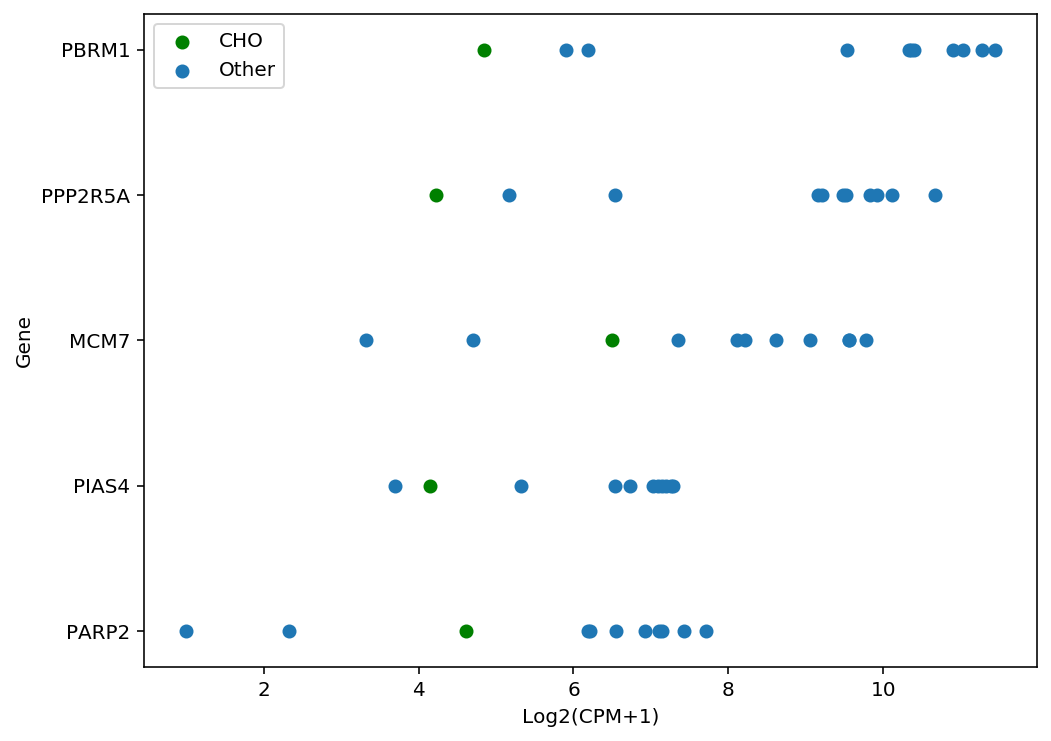

In [111]:
repair_genes = ["Mcm7",
                "Ppp2r5a",
                "Pias4",
                "Pbrm1",
                "Parp2"]

curr_genes = pd.concat((repair_df, repair_cho_df), axis=1)
# Go into log2
curr_genes = np.log2(curr_genes+1)
gene_tpm_ratio = (curr_genes.drop("CHO",axis=1).mean(axis=1) - curr_genes["CHO"])
gene_tpm_ratio


curr_order = curr_genes.apply(lambda x: x.sum(), axis=1).sort_values().index
curr_genes = curr_genes.loc[curr_order]
zip(range(len(curr_genes)), curr_genes.index)

# Construct scatter values
cho_scatter_x = []
cho_scatter_y = []
tissue_scatter_x = []
tissue_scatter_y = []
n_tissues = curr_genes.shape[1] - 1
for i in zip(range(len(curr_genes)), curr_genes.index):
    cho_scatter_y.append(i[0])
    cho_scatter_x.append(curr_genes.loc[i[1],"CHO"])
    tissue_scatter_y += [i[0]] * n_tissues
    tissue_scatter_x += list(curr_genes.drop("CHO",axis=1).loc[i[1]].values)


f, ax = plt.subplots()
ax.scatter(cho_scatter_x,cho_scatter_y,color="g")
ax.scatter(tissue_scatter_x,tissue_scatter_y)
plt.ylabel("Gene")
plt.xlabel("Log2(CPM+1)")
ax.set_yticks(range(len(cho_scatter_y)))
ax.set_yticklabels(curr_genes.index.values);

plt.legend(["CHO","Other"])
name = os.path.join(save_dir,"repair_genes")


# Save
#helper_save(name+"_log2")

# plt.savefig(name+"_log2.png")
# plt.savefig(name+"_log2.eps")
#gene_tpm_ratio.to_csv(name + "_log2_ratio.txt")

print("CPM ratio", gene_tpm_ratio)
print(curr_genes)